# Expectation-Maximization Model (Gaussian Mixture Model)

In this problem, we will implement the EM algorithm for clustering. Start by importing the required
packages and preparing the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as LA
from matplotlib.patches import Ellipse
from sklearn.datasets.samples_generator import make_blobs

In [2]:
def load_data():
    K = 3
    NUM_DATAPTS = 150

    X,y = make_blobs(n_samples=NUM_DATAPTS, 
                     centers=K,shuffle=False, 
                     random_state=0,
                     cluster_std=0.6)

    g1 = np.asarray([[2.0,0],[-0.9,1]])
    g2 = np.asarray([[1.4,0],[0.5,0.7]])

    mean1 = np.mean(X[:int(NUM_DATAPTS/K)])
    mean2 = np.mean(X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)])

    X[:int(NUM_DATAPTS/K)] = np.einsum('nj, ij -> ni',
                                       X[:int(NUM_DATAPTS/K)] - mean1, g1) + mean1
    X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)] = np.einsum('nj, ij -> ni',
                                                          X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)] - mean2,
                                                           g2) + mean2
    X[:,1] -= 4
    return X

## a) Initialize $\mu_k, \Sigma_k, \pi_k$

- Randomly initialize a numpy array `MEANS` of shape (K, 2) to represent the mean of the clusters,
- initialize an array `COVARIANCES` of shape (K, 2, 2) such that cov[k] is the identity matrix for each k. `COVARIANCES` will be used to represent the covariance matrices of the clusters. 
- Finally, set pi `CLUSTERING_COEFFICIENTS` to be the uniform distribution at the start of the program.

In [3]:
def init_centroids(X, n_cluster):
    N, d = X.shape
    mean_indices = [np.random.randint(N)]
    for j in range(n_cluster-1):
        furthest_distance = 0
        furthest_point_index = None
        for i in range(N):
            if i in mean_indices:
                continue

            current_point = X[i]
            current_distance = sum([sum((current_point - X[index])**2) for index in mean_indices])

            if current_distance > furthest_distance:
                furthest_distance = current_distance
                furthest_point_index = i

        mean_indices.append(furthest_point_index)
    return X[mean_indices]

def initialize(X):
    N, d = X.shape
    MEANS = init_centroids(X, n_cluster=3)
    COVARIANCES = np.array([np.eye(N=d) for _ in range(K)])
    CLUSTER_COEFFICIENTS = np.random.uniform(size=(K))
    return MEANS, COVARIANCES, CLUSTER_COEFFICIENTS

K = 3
NUM_DATAPTS = 150
X = load_data()
MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = initialize(X)

print(f"Means: \n{MEANS}\n")
print(f"Covariance Matrix: \n{COVARIANCES}\n")
print(f"Cluster Coefficient (pi): \n{CLUSTER_COEFFICIENTS}")

Means: 
[[-1.11198076 -0.66526825]
 [ 4.27095142 -1.53650922]
 [-3.75534522  3.57579775]]

Covariance Matrix: 
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

Cluster Coefficient (pi): 
[0.56691288 0.62523662 0.51893274]


## E-step:
Evaluate the responsibilities using the current parameter values:
$$ 
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{k}, \mathbf{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{j}, \mathbf{\Sigma}_{j}\right)}
 $$
 where
$$ 
\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \mathbf{\Sigma})=\frac{1}{(2 \pi)^{D / 2}} \frac{1}{|\mathbf{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right\}
 $$

In [4]:
def multivariate_gaussian_pdf(x, mu, sigma):
    D = x.shape[0]
    exp_term = np.exp(-0.5*(x - mu).T@np.linalg.inv(sigma)@(x - mu))
    a = 1/ (np.sqrt(2*np.pi)**D)
    b = 1/np.sqrt(LA.det(sigma))
    return a*b*exp_term

def calc_gamma(x, cluster_idx):
    mu = MEANS[cluster_idx]
    sigma = COVARIANCES[cluster_idx]
    pi_k = CLUSTER_COEFFICIENTS[cluster_idx]
    gamma =  pi_k*multivariate_gaussian_pdf(x, mu, sigma) / sum([CLUSTER_COEFFICIENTS[cluster_j]*multivariate_gaussian_pdf(x, MEANS[cluster_j], COVARIANCES[cluster_j]) 
     for cluster_j in range(K)])
    return gamma

def E_step():
    gamma = np.zeros((NUM_DATAPTS, K))
    for i in range(NUM_DATAPTS):
        x = X[i]
        for cluster_idx in range(K):
            current_gamma = calc_gamma(x, cluster_idx)
            gamma[i, cluster_idx] = current_gamma
    return gamma

## M-step
Re-estimate the parameters using the current responsibilities $\gamma\left(z_{n k}\right)$
- $ {\mu}_{k}^{\text { new }}=\frac{1}{N_{k}} \sum_{n=1}^{N}\gamma\left(z_{n k}\right) \mathbf{x}_{n}$
- $ {\Sigma}_{k}^{\mathrm{new}}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-\boldsymbol{\mu}_{k}^{\mathrm{new}}\right)\left(\mathbf{x}_{n}-\boldsymbol{\mu}_{k}^{\mathrm{new}}\right)^{\mathrm{T}}$
- $\pi_{k}^{\text { new }}=\frac{N_{k}}{N}$

where
$N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)$, in the code below, we call this `N_effect` where it is the effective number of points in a cluster.

$\sum_{j=1}^{K} N_{j}$ = `NUM_DATAPTS`

In [5]:
def M_step(gamma):
    N_effect = np.sum(gamma, axis=0)
    MEANS = np.array([
        (1/N_effect[cluster_idx]) * sum([gamma[i, cluster_idx]*X[i] for i in range(NUM_DATAPTS)])
              for cluster_idx in range(K)])
    
    COVARIANCES = np.zeros((3,2,2))
    for cluster_idx in range(K):
        mean = MEANS[cluster_idx]       
        sigma_k = 0
        for i in range(NUM_DATAPTS):
            x = X[i]
            x_minus_mu = (x - mean).reshape(-1,1)
            sigma_k += gamma[i, cluster_idx]*x_minus_mu@(x_minus_mu.T)            
        COVARIANCES[cluster_idx] = (1/N_effect[cluster_idx] * sigma_k)

    CLUSTER_COEFFICIENTS = [N_k/NUM_DATAPTS for N_k in N_effect]
    
    return MEANS, COVARIANCES, CLUSTER_COEFFICIENTS

## Now write a loop that iterates through the E and M steps

That Terminates after the change in log-likelihood is below some threshold (In our case we set this to be 0.01)

The log-likelihood formula is as follows:
$$ 
\ln p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} | \boldsymbol{\mu}_{k}, \mathbf{\Sigma}_{k}\right)\right\}
 $$

In [6]:
def log_likelihood(X, mu, sigma, cluster_coef):
    ll = 0
    for i in range(NUM_DATAPTS):
        x = X[i]
        ll_i = 0
        for cluster_idx in range(K):
            ll_i += cluster_coef[cluster_idx]*multivariate_gaussian_pdf(x, mu[cluster_idx], sigma[cluster_idx])
        ll += np.log(ll_i)
    return ll

def plot_result(gamma=None):
    ax = plt.subplot(111, aspect='equal')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.scatter(X[:, 0], X[:, 1], c=gamma, s=50, cmap=None)
    
    for k in range(K):
        l, v = LA.eig(COVARIANCES[k])
        theta = np.arctan(v[1,0]/v[0,0])
        e = Ellipse((MEANS[k,0],MEANS[k,1]),6*l[0],6*l[1],
                    theta*180/np.pi)
        e.set_alpha(0.5)
        ax.add_artist(e)
    plt.show()

At each iteration, 
- `E_step` to calculate `gamma`
- `M_step` using this `gamma` to calculate the new `MEANS`, `COVARIANCES` and `CLUSTER_COEFFICIENTS`
- print out the log-likelihood, and use
- the following function (`plot_result`) to plot the progress of the algorithm:

Log Likelihood: -567.9719716832861
Improvement: inf


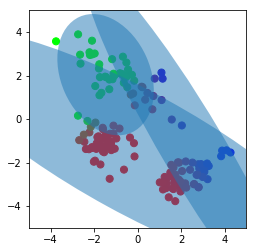

Log Likelihood: -540.8502112934331
Improvement: 27.12176038985308


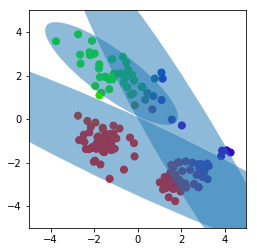

Log Likelihood: -530.2076018580842
Improvement: 10.642609435348845


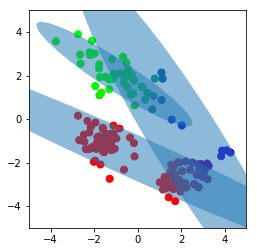

Log Likelihood: -528.2507036116318
Improvement: 1.956898246452397


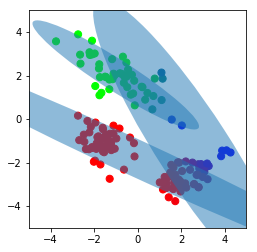

Log Likelihood: -526.3245225697591
Improvement: 1.9261810418727237


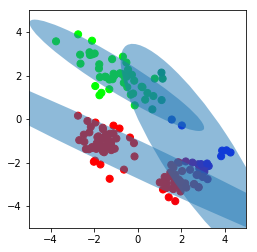

Log Likelihood: -522.1162917237276
Improvement: 4.2082308460314835


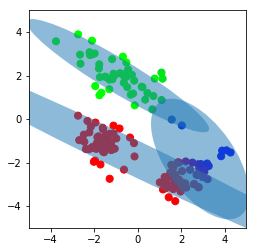

Log Likelihood: -515.5827904741524
Improvement: 6.533501249575238


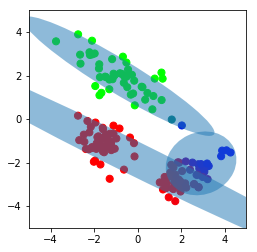

Log Likelihood: -505.9770911730427
Improvement: 9.605699301109667


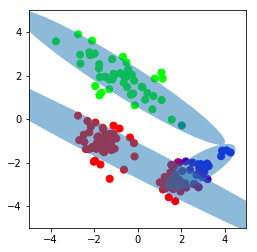

Log Likelihood: -499.77049173203426
Improvement: 6.20659944100845


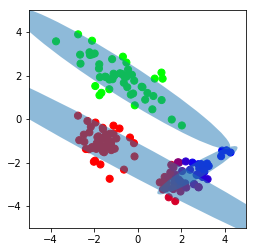

Log Likelihood: -495.6223036920505
Improvement: 4.148188039983779


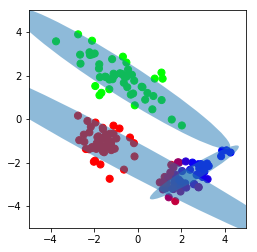

Log Likelihood: -491.2320386690718
Improvement: 4.390265022978667


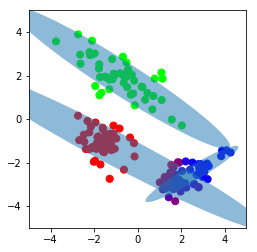

Log Likelihood: -485.13888388203554
Improvement: 6.093154787036269


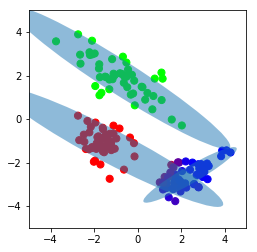

Log Likelihood: -474.2141682232718
Improvement: 10.924715658763716


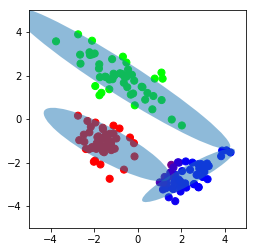

Log Likelihood: -463.6618408864275
Improvement: 10.552327336844314


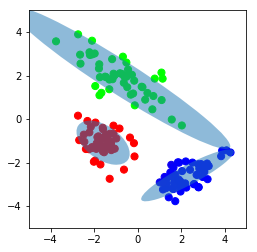

Log Likelihood: -463.34194408588917
Improvement: 0.3198968005383449


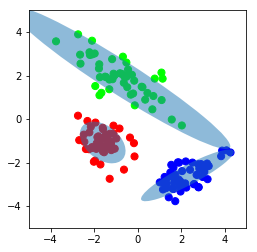

Algorithm converges within 15 iterations


In [7]:
K = 3
NUM_DATAPTS = 150
X = load_data()
MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = initialize(X)
MEANS = init_centroids(X, K)

max_iter = 50;

prev_ll = -np.inf
for _ in range(max_iter):
    gamma = E_step()
    MEANS, COVARIANCES, CLUSTER_COEFFICIENTS = M_step(gamma)
    ll = log_likelihood(X, MEANS, COVARIANCES, CLUSTER_COEFFICIENTS)
    improvement = ll - prev_ll
    prev_ll = ll
    
    # stopping condition: if converge
    if improvement < 0.01:
        print(f"Algorithm converges within {_} iterations")
        break
        
    print(f"Log Likelihood: {ll}")
    print(f"Improvement: {improvement}")    
    plot_result(gamma)